In [1]:
print("Setup Complete")

Setup Complete


In [2]:
DATA_PATH = './dataset/combine.dataset.csv'

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from joblib import dump, load

# Read the data
X_full = pd.read_csv(DATA_PATH)

# Drop irrelative columns
X_full = X_full.drop(columns=['rank', 'tconst', 'page'])

# Drop rows including na or invalid value
X_full = X_full.dropna()
X_full = X_full[X_full.runtime != '\\'+'N']
X_full = X_full[X_full.genres != str(['\\N'])]

# Convert dollar format to float
X_full[['worldwide']] = X_full[['worldwide']].replace('[\$,]','',regex=True).astype(float)

# Convert string format to int 
X_full[['runtime']] = X_full[['runtime']].astype(int)

# Convert string to list
X_full['genres'] = X_full['genres'].str[2:-2].str.split(',')

# Get X and y
features = ['year', 'title', 'imdbRate', 'runtime', 'genres', 'directors']
X = X_full[features]
y = X_full.worldwide

print(y)

from sklearn.preprocessing import MultiLabelBinarizer

# Encode genres
mlb = MultiLabelBinarizer()
genres_df = pd.DataFrame(mlb.fit_transform(X['genres']),columns=mlb.classes_, index=X.index)
X = X.join(genres_df)
X = X.drop(columns=['genres'])

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=0)

from sklearn.preprocessing import OneHotEncoder
object_cols = ['title', 'directors']
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)


0       1.486658e+09
1       1.001136e+09
2       9.557758e+08
4       7.708362e+08
5       7.609281e+08
            ...     
2594    1.925916e+07
2595    1.911572e+07
2596    1.887608e+07
2597    1.868906e+07
2598    1.849504e+07
Name: worldwide, Length: 2297, dtype: float64


In [7]:
for col in X.columns:
    print(col)

year
title
imdbRate
runtime
directors
Action
Adventure
Animation
Biography
Comedy
Crime
Documentary
Drama
Family
Fantasy
History
Horror
Music
Musical
Mystery
Romance
Sci-Fi
Short
Sport
Thriller
War
Western


In [40]:
X_full.to_csv('./dataset/cleaned.dataset.csv')  

In [41]:
error_dict1 = {}
error_dict2 = {}
error_dict3 = {}
error_dict4 = {}
error_dict5 = {}
error_dict6 = {}

/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error 

Mean Absolute Error: 85350848.77856521
Mean Squared Error: 2.7580692814171464e+16
Root Mean Squared Error: 166074359.29176864
Sqaured Mean Error: 166074359.29
R squared training: 0.9
R sqaured testing: 0.342


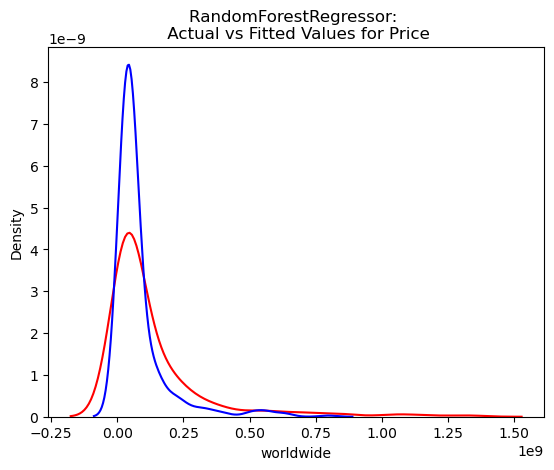

['models/RF_model.joblib']

In [42]:
from sklearn.ensemble import RandomForestRegressor

# Define the model
RF_model = RandomForestRegressor(n_estimators=50, random_state=0)

# Fit the model to the training data
RF_model.fit(OH_X_train, y_train)

# Generate test predictions
preds_test = RF_model.predict(OH_X_valid)

# Score the prediction
import sklearn.metrics as metrics
error_dict1["RandomForestRegressor"] = metrics.mean_absolute_error(y_valid, preds_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, preds_test)) 
error_dict2["RandomForestRegressor"] = metrics.mean_squared_error(y_valid, preds_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, preds_test)) 
mean_squared_error=metrics.mean_squared_error(y_valid, preds_test)
error_dict3["RandomForestRegressor"] = np.sqrt(metrics.mean_squared_error(y_valid, preds_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, preds_test)))
error_dict4["RandomForestRegressor"] = round(np.sqrt(mean_squared_error),2)
print('Sqaured Mean Error:', round(np.sqrt(mean_squared_error),2))
error_dict5["RandomForestRegressor"] = round(RF_model.score(OH_X_train,y_train),3)
print('R squared training:',round(RF_model.score(OH_X_train,y_train),3))
error_dict6["RandomForestRegressor"] = round(RF_model.score(OH_X_valid,y_valid),3)
print('R sqaured testing:',round(RF_model.score(OH_X_valid,y_valid),3))

ax = sns.distplot(y_valid, hist=False, color="r", label="Actual Value")
sns.distplot(preds_test, hist=False, color="b", label="Fitted Values" , ax=ax)

plt.title('RandomForestRegressor: \n Actual vs Fitted Values for Price')
plt.show()
plt.close()

dump(RF_model, 'models/RF_model.joblib')

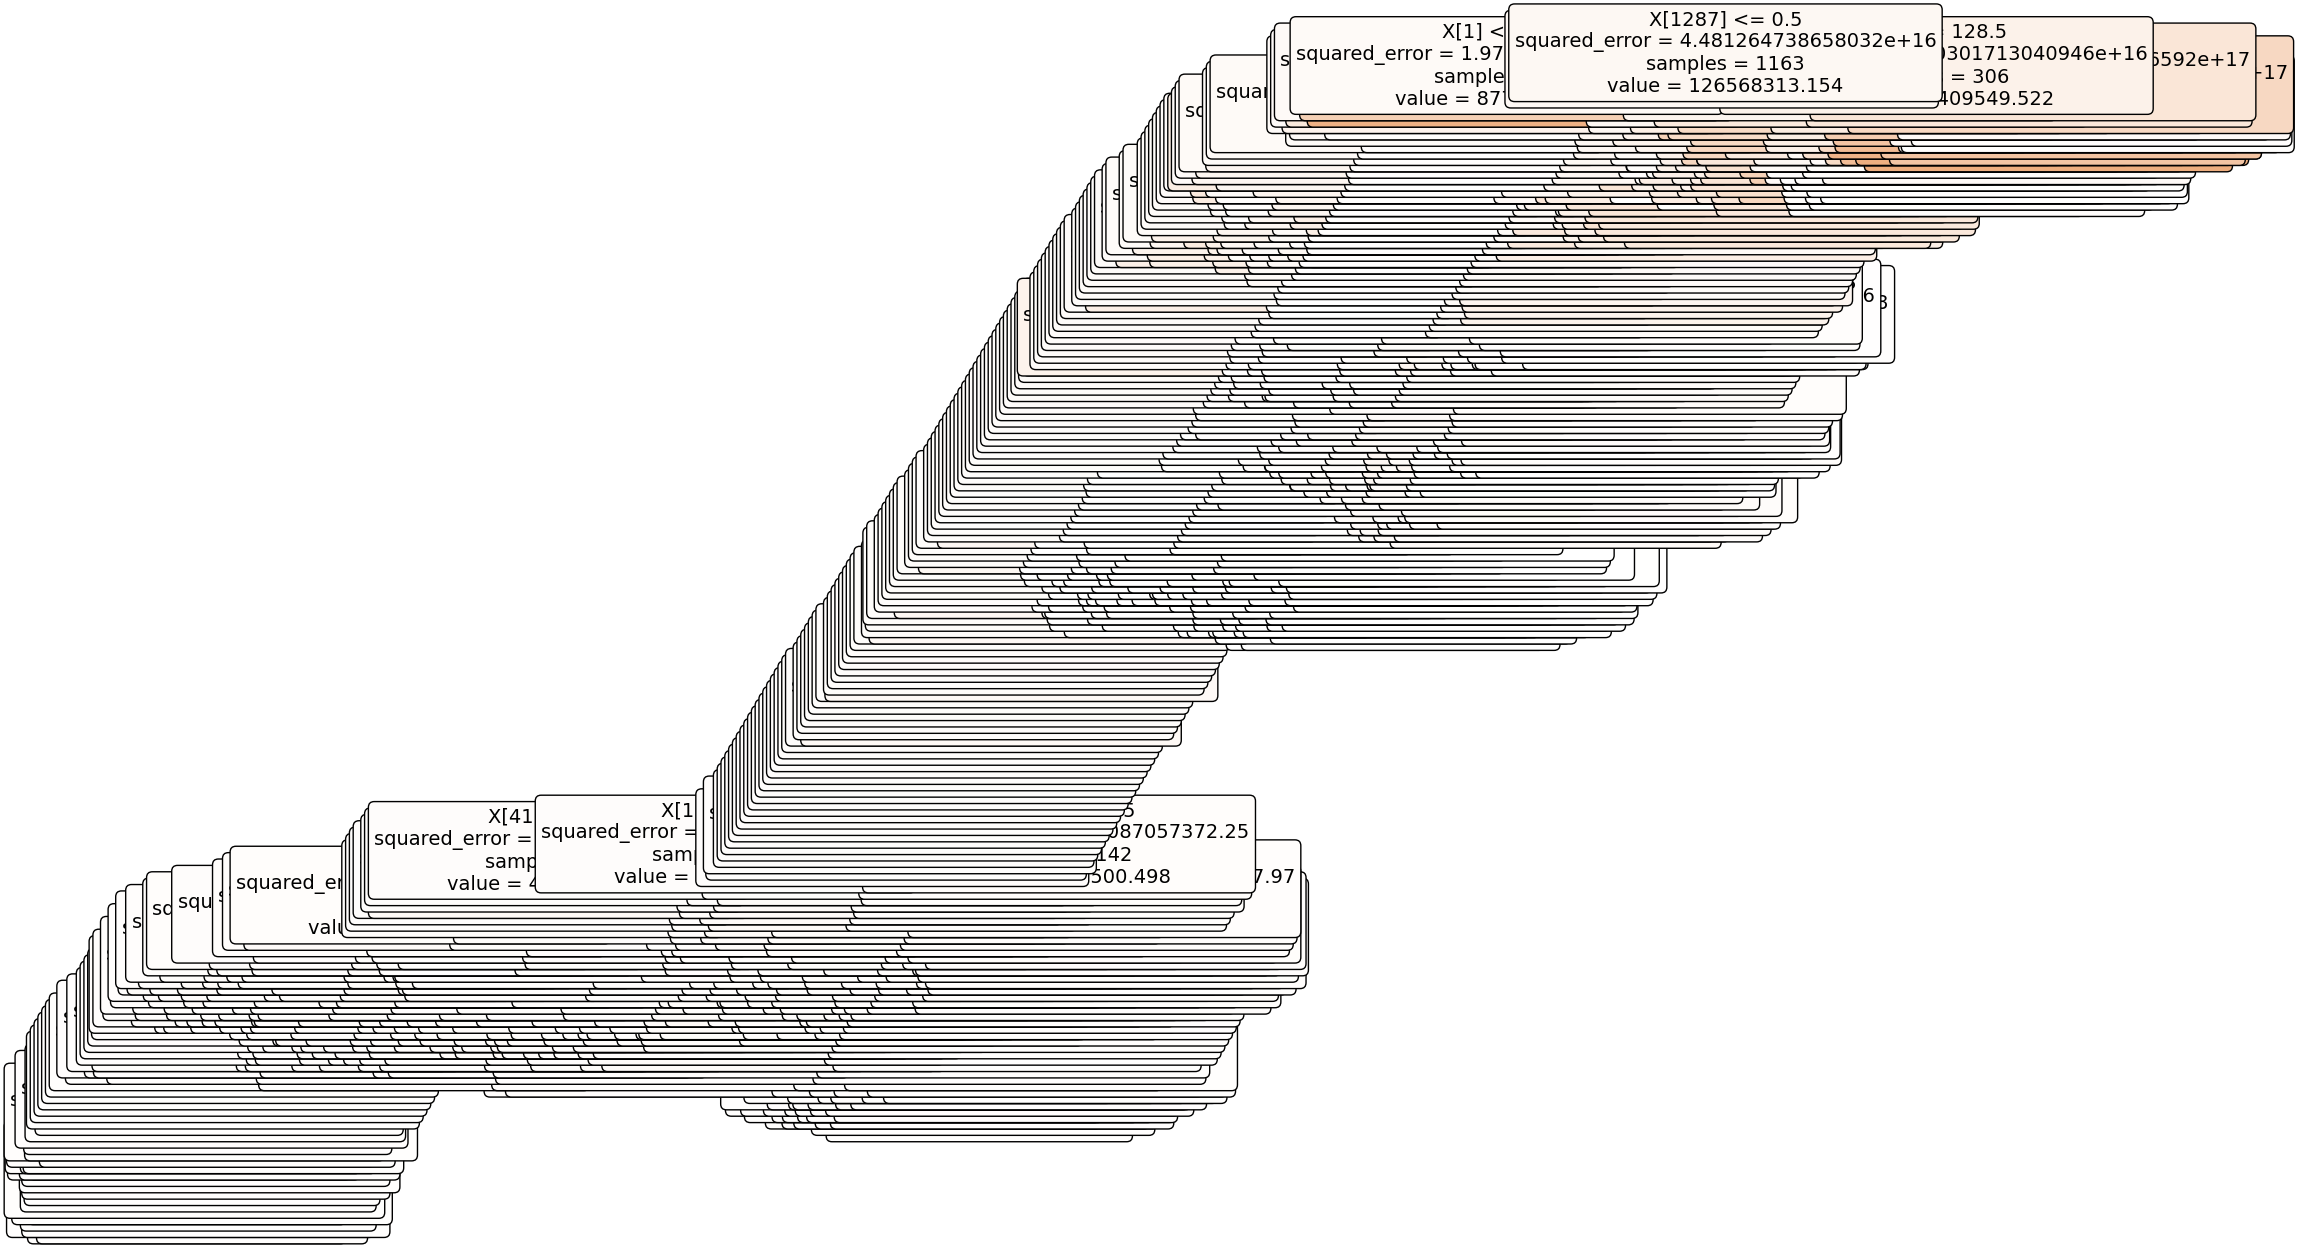

In [43]:
# Visualize the random forest 
import pydot
# Pull out one tree from the forest
Tree = RF_model.estimators_[5]
# Export the image to a dot file
from sklearn import tree
plt.figure(figsize=(25,15))
tree.plot_tree(Tree,filled=True, 
              rounded=True, 
              fontsize=14);

/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error 

Mean Absolute Error: 100099030.61825234
Mean Squared Error: 2.6911936365818844e+16
Root Mean Squared Error: 164048579.2861945
Sqaured Mean Error: 164048579.29
R squared training: 0.9
R sqaured testing: 0.342


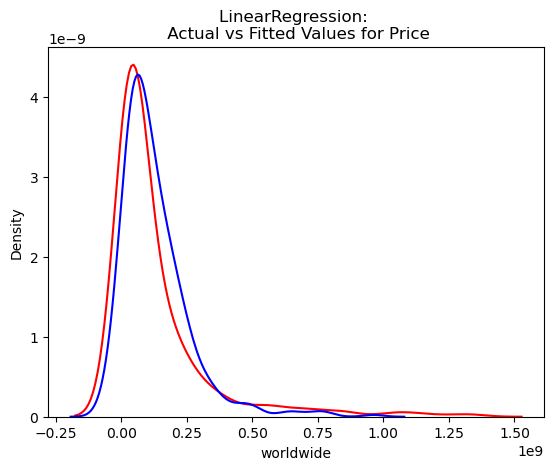

['models/lr_model.joblib']

In [44]:
# Linear Regression 

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

# Define the model
lr_model = LinearRegression()

# Fit the model to the training data
lr_model.fit(OH_X_train, y_train)

# Generate test predictions
preds_test = lr_model.predict(OH_X_valid)

# Score the prediction
import sklearn.metrics as metrics
error_dict1["LinearRegression"] = metrics.mean_absolute_error(y_valid, preds_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, preds_test)) 
error_dict2["LinearRegression"] = metrics.mean_squared_error(y_valid, preds_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, preds_test)) 
mean_squared_error=metrics.mean_squared_error(y_valid, preds_test)
error_dict3["LinearRegression"] = np.sqrt(metrics.mean_squared_error(y_valid, preds_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, preds_test)))
error_dict4["LinearRegression"] = round(np.sqrt(mean_squared_error),2)
print('Sqaured Mean Error:', round(np.sqrt(mean_squared_error),2))
error_dict5["LinearRegression"] = round(RF_model.score(OH_X_train,y_train),3)
print('R squared training:',round(RF_model.score(OH_X_train,y_train),3))
error_dict6["LinearRegression"] = round(RF_model.score(OH_X_valid,y_valid),3)
print('R sqaured testing:',round(RF_model.score(OH_X_valid,y_valid),3))

ax = sns.distplot(y_valid, hist=False, color="r", label="Actual Value")
sns.distplot(preds_test, hist=False, color="b", label="Fitted Values" , ax=ax)

plt.title('LinearRegression: \n Actual vs Fitted Values for Price')
plt.show()
plt.close()

dump(lr_model, 'models/lr_model.joblib')

/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Mean Absolute Error: 104308704.00112563
Mean Squared Error: 4.8256729916512504e+16
Root Mean Squared Error: 219674144.85212526
Sqaured Mean Error: 219674144.85
R squared training: 0.9
R sqaured testing: 0.342


/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error 

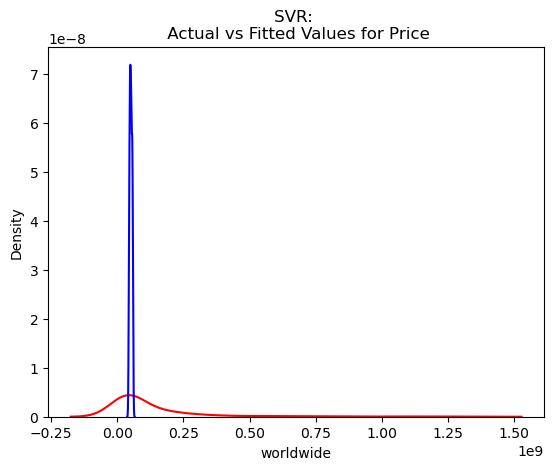

['models/svr.joblib']

In [45]:
# SVM regressor

from sklearn.svm import SVR

# Define the model
svr = SVR(kernel = 'linear',C = 1000)

# Fit the model to the training data
svr.fit(OH_X_train, y_train)

# Generate test predictions
preds_test = svr.predict(OH_X_valid)

# Score the prediction
import sklearn.metrics as metrics
error_dict1["SVR"] = metrics.mean_absolute_error(y_valid, preds_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, preds_test)) 
error_dict2["SVR"] = metrics.mean_squared_error(y_valid, preds_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, preds_test)) 
mean_squared_error=metrics.mean_squared_error(y_valid, preds_test)
error_dict3["SVR"] = np.sqrt(metrics.mean_squared_error(y_valid, preds_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, preds_test)))
error_dict4["SVR"] = round(np.sqrt(mean_squared_error),2)
print('Sqaured Mean Error:', round(np.sqrt(mean_squared_error),2))
error_dict5["SVR"] = round(RF_model.score(OH_X_train,y_train),3)
print('R squared training:',round(RF_model.score(OH_X_train,y_train),3))
error_dict6["SVR"] = round(RF_model.score(OH_X_valid,y_valid),3)
print('R sqaured testing:',round(RF_model.score(OH_X_valid,y_valid),3))

ax = sns.distplot(y_valid, hist=False, color="r", label="Actual Value")
sns.distplot(preds_test, hist=False, color="b", label="Fitted Values" , ax=ax)

plt.title('SVR: \n Actual vs Fitted Values for Price')
plt.show()
plt.close()

dump(svr, 'models/svr.joblib')

/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']

Mean Absolute Error: 136233328.71086955
Mean Squared Error: 6.0708187370280664e+16
Root Mean Squared Error: 246390315.0902662
Sqaured Mean Error: 246390315.09
R squared training: 0.9
R sqaured testing: 0.342


/var/folders/53/n7rd6d9d4sjb_g5xkbjjdjnm0000gn/T/ipykernel_19695/3049491908.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_valid, hist=False, color="r", label="Actual Value")
/var/folders/53/n7rd6d9d4sjb_g5xkbjjdjnm0000gn/T/ipykernel_19695/3049491908.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2

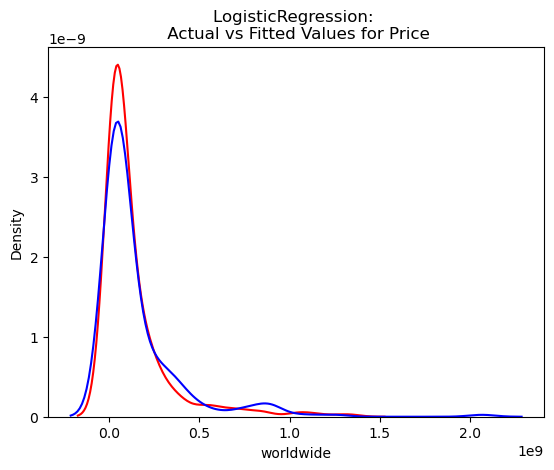

['models/logmodel.joblib']

In [46]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()  

logmodel.fit(OH_X_train, y_train)

# Generate test predictions
preds_test = logmodel.predict(OH_X_valid)

# Score the prediction
import sklearn.metrics as metrics
error_dict1["LogisticRegression"] = metrics.mean_absolute_error(y_valid, preds_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, preds_test)) 
error_dict2["LogisticRegression"] = metrics.mean_squared_error(y_valid, preds_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, preds_test)) 
mean_squared_error=metrics.mean_squared_error(y_valid, preds_test)
error_dict3["LogisticRegression"] = np.sqrt(metrics.mean_squared_error(y_valid, preds_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, preds_test)))
error_dict4["LogisticRegression"] = round(np.sqrt(mean_squared_error),2)
print('Sqaured Mean Error:', round(np.sqrt(mean_squared_error),2))
error_dict5["LogisticRegression"] = round(RF_model.score(OH_X_train,y_train),3)
print('R squared training:',round(RF_model.score(OH_X_train,y_train),3))
error_dict6["LogisticRegression"] = round(RF_model.score(OH_X_valid,y_valid),3)
print('R sqaured testing:',round(RF_model.score(OH_X_valid,y_valid),3))

ax = sns.distplot(y_valid, hist=False, color="r", label="Actual Value")
sns.distplot(preds_test, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('LogisticRegression: \n Actual vs Fitted Values for Price')
plt.show()
plt.close()

dump(logmodel, 'models/logmodel.joblib')

/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error 

Mean Absolute Error: 115191292.56304348
Mean Squared Error: 5.4566670073990904e+16
Root Mean Squared Error: 233595098.5658537
Sqaured Mean Error: 233595098.57
R squared training: 0.9
R sqaured testing: 0.342


/var/folders/53/n7rd6d9d4sjb_g5xkbjjdjnm0000gn/T/ipykernel_19695/1662484526.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_valid, hist=False, color="r", label="Actual Value")
/var/folders/53/n7rd6d9d4sjb_g5xkbjjdjnm0000gn/T/ipykernel_19695/1662484526.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2

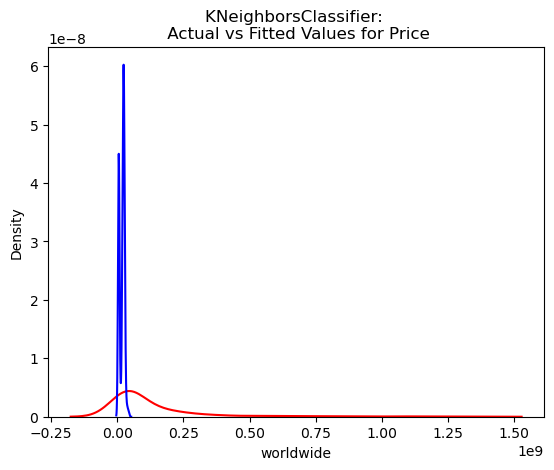

['models/knn.joblib']

In [47]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=13,p=2,metric='euclidean')

knn.fit(OH_X_train, y_train)

# Generate test predictions
preds_test = knn.predict(OH_X_valid)

# Score the prediction
import sklearn.metrics as metrics
error_dict1["KNeighborsClassifier"] = metrics.mean_absolute_error(y_valid, preds_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, preds_test)) 
error_dict2["KNeighborsClassifier"] = metrics.mean_squared_error(y_valid, preds_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, preds_test)) 
mean_squared_error=metrics.mean_squared_error(y_valid, preds_test)
error_dict3["KNeighborsClassifier"] = np.sqrt(metrics.mean_squared_error(y_valid, preds_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, preds_test)))
error_dict4["KNeighborsClassifier"] = round(np.sqrt(mean_squared_error),2)
print('Sqaured Mean Error:', round(np.sqrt(mean_squared_error),2))
error_dict5["KNeighborsClassifier"] = round(RF_model.score(OH_X_train,y_train),3)
print('R squared training:',round(RF_model.score(OH_X_train,y_train),3))
error_dict6["KNeighborsClassifier"] = round(RF_model.score(OH_X_valid,y_valid),3)
print('R sqaured testing:',round(RF_model.score(OH_X_valid,y_valid),3))

ax = sns.distplot(y_valid, hist=False, color="r", label="Actual Value")
sns.distplot(preds_test, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('KNeighborsClassifier: \n Actual vs Fitted Values for Price')
plt.show()
plt.close()

dump(knn, 'models/knn.joblib')

/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error 

Mean Absolute Error: 100099030.61825234
Mean Squared Error: 2.6911936365818844e+16
Root Mean Squared Error: 164048579.2861945
Sqaured Mean Error: 164048579.29
R squared training: 0.9
R sqaured testing: 0.342


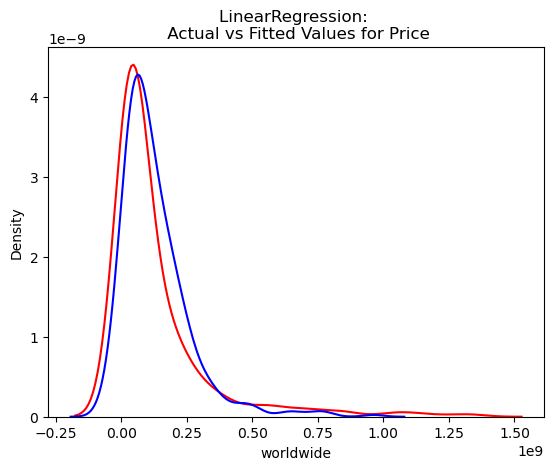

['models/regr.joblib']

In [48]:
# Multiple regression
from sklearn import linear_model

regr = linear_model.LinearRegression()

regr.fit(OH_X_train, y_train)

# Generate test predictions
preds_test = regr.predict(OH_X_valid)

# Score the prediction
import sklearn.metrics as metrics
error_dict1["LinearRegression"] = metrics.mean_absolute_error(y_valid, preds_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, preds_test)) 
error_dict2["LinearRegression"] = metrics.mean_squared_error(y_valid, preds_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, preds_test)) 
mean_squared_error=metrics.mean_squared_error(y_valid, preds_test)
error_dict3["LinearRegression"] = np.sqrt(metrics.mean_squared_error(y_valid, preds_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, preds_test)))
error_dict4["LinearRegression"] = round(np.sqrt(mean_squared_error),2)
print('Sqaured Mean Error:', round(np.sqrt(mean_squared_error),2))
error_dict5["LinearRegression"] = round(RF_model.score(OH_X_train,y_train),3)
print('R squared training:',round(RF_model.score(OH_X_train,y_train),3))
error_dict6["LinearRegression"] = round(RF_model.score(OH_X_valid,y_valid),3)
print('R sqaured testing:',round(RF_model.score(OH_X_valid,y_valid),3))

ax = sns.distplot(y_valid, hist=False, color="r", label="Actual Value")
sns.distplot(preds_test, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('LinearRegression: \n Actual vs Fitted Values for Price')
plt.show()
plt.close()

dump(regr, 'models/regr.joblib')

/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error 

Mean Absolute Error: 96311977.54517508
Mean Squared Error: 2.7228276106450292e+16
Root Mean Squared Error: 165009927.29666385
Sqaured Mean Error: 165009927.3
R squared training: 0.9
R sqaured testing: 0.342


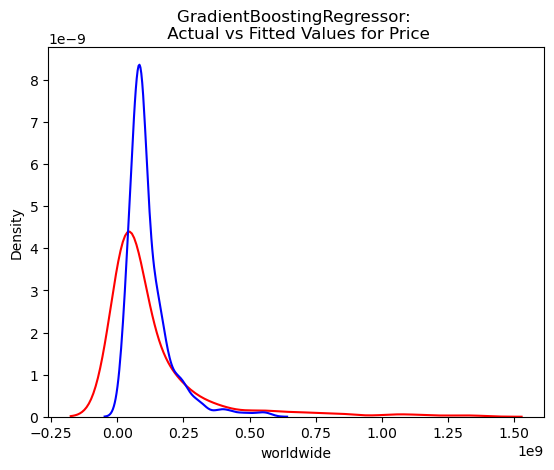

['models/gbr.joblib']

In [49]:
# Gradient Boosting Regression

# Multiple regression
from sklearn import ensemble

gbr = ensemble.GradientBoostingRegressor()

gbr.fit(OH_X_train, y_train)

# Generate test predictions
preds_test = gbr.predict(OH_X_valid)

# Score the prediction
import sklearn.metrics as metrics
error_dict1["GradientBoostingRegressor"] = metrics.mean_absolute_error(y_valid, preds_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, preds_test)) 
error_dict2["GradientBoostingRegressor"] = metrics.mean_squared_error(y_valid, preds_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, preds_test)) 
mean_squared_error=metrics.mean_squared_error(y_valid, preds_test)
error_dict3["GradientBoostingRegressor"] = np.sqrt(metrics.mean_squared_error(y_valid, preds_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, preds_test)))
error_dict4["GradientBoostingRegressor"] = round(np.sqrt(mean_squared_error),2)
print('Sqaured Mean Error:', round(np.sqrt(mean_squared_error),2))
error_dict5["GradientBoostingRegressor"] = round(RF_model.score(OH_X_train,y_train),3)
print('R squared training:',round(RF_model.score(OH_X_train,y_train),3))
error_dict6["GradientBoostingRegressor"] = round(RF_model.score(OH_X_valid,y_valid),3)
print('R sqaured testing:',round(RF_model.score(OH_X_valid,y_valid),3))

ax = sns.distplot(y_valid, hist=False, color="r", label="Actual Value")
sns.distplot(preds_test, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('GradientBoostingRegressor: \n Actual vs Fitted Values for Price')
plt.show()
plt.close()

dump(gbr, 'models/gbr.joblib')


/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Mean Absolute Error: 87134556.2464674
Mean Squared Error: 2.439185719542808e+16
Root Mean Squared Error: 156178926.86091834
Sqaured Mean Error: 156178926.86
R squared training: 0.9
R sqaured testing: 0.342


/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/wanghanlun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error 

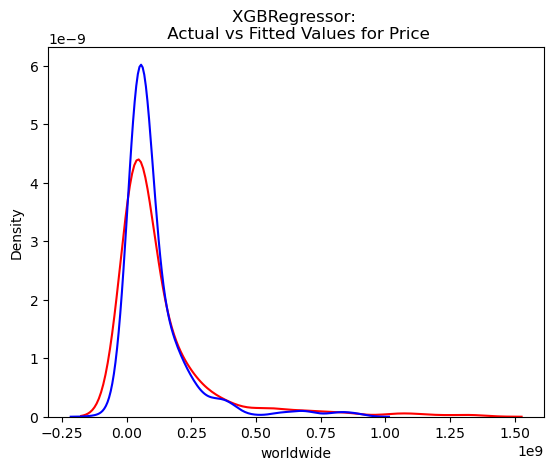

['models/xgb_model.joblib']

In [50]:
# xg boost

import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

xgb_model.fit(OH_X_train, y_train)

# Generate test predictions
preds_test = xgb_model.predict(OH_X_valid)

# Score the prediction
import sklearn.metrics as metrics
error_dict1["XGBRegressor"] = metrics.mean_absolute_error(y_valid, preds_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, preds_test)) 
error_dict2["XGBRegressor"] = metrics.mean_squared_error(y_valid, preds_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, preds_test)) 
mean_squared_error=metrics.mean_squared_error(y_valid, preds_test)
error_dict3["XGBRegressor"] = np.sqrt(metrics.mean_squared_error(y_valid, preds_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, preds_test)))
error_dict4["XGBRegressor"] = round(np.sqrt(mean_squared_error),2)
print('Sqaured Mean Error:', round(np.sqrt(mean_squared_error),2))
error_dict5["XGBRegressor"] = round(RF_model.score(OH_X_train,y_train),3)
print('R squared training:',round(RF_model.score(OH_X_train,y_train),3))
error_dict6["XGBRegressor"] = round(RF_model.score(OH_X_valid,y_valid),3)
print('R sqaured testing:',round(RF_model.score(OH_X_valid,y_valid),3))


ax = sns.distplot(y_valid, hist=False, color="r", label="Actual Value")
sns.distplot(preds_test, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('XGBRegressor: \n Actual vs Fitted Values for Price')
plt.show()

dump(xgb_model, 'models/xgb_model.joblib')

In [51]:
# Rank models according to Test set accuracy
print('Mean Absolute Error:')
sorted_error_dict1 = sorted(error_dict1.items(), key = lambda kv: (-kv[1], kv[0]))
rank = 1
for kv in sorted_error_dict1:
    print("Rank " + str(rank) + ": " + kv[0] + ": " + str(kv[1]) + "\n")
    rank += 1
print('Mean Absolute Error:')
sorted_error_dict2 = sorted(error_dict2.items(), key = lambda kv: (-kv[1], kv[0]))
rank = 1
for kv in sorted_error_dict2:
    print("Rank " + str(rank) + ": " + kv[0] + ": " + str(kv[1]) + "\n")
    rank += 1
print('Root Mean Squared Error:')
sorted_error_dict3 = sorted(error_dict3.items(), key = lambda kv: (-kv[1], kv[0]))
rank = 1
for kv in sorted_error_dict3:
    print("Rank " + str(rank) + ": " + kv[0] + ": " + str(kv[1]) + "\n")
    rank += 1
print('Sqaured Mean Error:')
sorted_error_dict4 = sorted(error_dict4.items(), key = lambda kv: (-kv[1], kv[0]))
rank = 1
for kv in sorted_error_dict4:
    print("Rank " + str(rank) + ": " + kv[0] + ": " + str(kv[1]) + "\n")
    rank += 1
print('R squared training:')
sorted_error_dict5 = sorted(error_dict5.items(), key = lambda kv: (-kv[1], kv[0]))
rank = 1
for kv in sorted_error_dict5:
    print("Rank " + str(rank) + ": " + kv[0] + ": " + str(kv[1]) + "\n")
    rank += 1
print('R sqaured testing:')
sorted_error_dict6 = sorted(error_dict6.items(), key = lambda kv: (-kv[1], kv[0]))
rank = 1
for kv in sorted_error_dict6:
    print("Rank " + str(rank) + ": " + kv[0] + ": " + str(kv[1]) + "\n")
    rank += 1

Mean Absolute Error:
Rank 1: LogisticRegression: 136233328.71086955

Rank 2: KNeighborsClassifier: 115191292.56304348

Rank 3: SVR: 104308704.00112563

Rank 4: LinearRegression: 100099030.61825234

Rank 5: GradientBoostingRegressor: 96311977.54517508

Rank 6: XGBRegressor: 87134556.2464674

Rank 7: RandomForestRegressor: 85350848.77856521

Mean Absolute Error:
Rank 1: LogisticRegression: 6.0708187370280664e+16

Rank 2: KNeighborsClassifier: 5.4566670073990904e+16

Rank 3: SVR: 4.8256729916512504e+16

Rank 4: RandomForestRegressor: 2.7580692814171464e+16

Rank 5: GradientBoostingRegressor: 2.7228276106450292e+16

Rank 6: LinearRegression: 2.6911936365818844e+16

Rank 7: XGBRegressor: 2.439185719542808e+16

Root Mean Squared Error:
Rank 1: LogisticRegression: 246390315.0902662

Rank 2: KNeighborsClassifier: 233595098.5658537

Rank 3: SVR: 219674144.85212526

Rank 4: RandomForestRegressor: 166074359.29176864

Rank 5: GradientBoostingRegressor: 165009927.29666385

Rank 6: LinearRegression: